In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt
from SWCPD import BaseDetector as SWDCP


BATCH_SIZE  =32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [2]:
all_batches = []
all_labels =[]
torch.manual_seed(10)
for x,y in test_dataloader:
    bs = x.shape[0]
    all_batches.append(x.flatten().reshape(bs,784))
    all_labels.append(y)

all_batches = torch.cat(all_batches,dim=0)
all_labels = torch.cat(all_labels,dim=0)

print(all_batches.shape)

torch.Size([10000, 784])


In [ ]:
seed = 42
rng = np.random.default_rng(seed)

In [3]:
Labels_Sampled = []
seed = 2025
rng = np.random.default_rng(seed)

for run in range(10):
    
    l = tuple(rng.choice(np.arange(10),3,replace=False))
    if l not in Labels_Sampled:
        Labels_Sampled.append(l)


print(Labels_Sampled)
def FilterData(all_batches,all_labels,lables):
    data = []
    cps = []
    for l in lables:
        d =all_batches[all_labels==l].detach().numpy()
        data.append(d[:500])
        cps.append(len(d[:500]))
    return np.vstack(data),np.cumsum(cps)[:-1]


FilterData(all_batches,all_labels,list(Labels_Sampled[0]))

[(3, 9, 8), (6, 5, 8), (0, 4, 3), (6, 7, 8), (4, 3, 0), (1, 9, 4), (2, 3, 5), (5, 2, 3), (9, 1, 8), (8, 4, 5)]


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([ 500, 1000]))

In [14]:
METRICS_SWD = {}
for id,i in enumerate(range(10)):
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = FilterData(all_batches,all_labels,list(Labels_Sampled[i]))
    print(GroundTruth)
    detector = SWDCP(data=df,window_length=50,max_history=50)
    print(detector.device)
    detector.process_dataloader(p=2,n_theta=1000)
    METRICS_SWD[id]['F1'] =f_measure({'0':GroundTruth},detector.change_points['loc'],margin=20)
    METRICS_SWD[id]['Covering'] = covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0])
    print(METRICS_SWD[id])

0
[ 500 1000]
cuda


 33%|███▎      | 479/1451 [00:05<00:10, 94.85it/s]

Change detected at: 519 
Initiate new segment


 68%|██████▊   | 984/1451 [00:10<00:04, 98.05it/s] 

Change detected at: 1015 
Initiate new segment


100%|██████████| 1451/1451 [00:15<00:00, 92.83it/s] 


{'F1': 1.0, 'Covering': 0.9557905731086045}
1
[ 500 1000]
cuda


 33%|███▎      | 486/1451 [00:05<00:10, 95.30it/s]

Change detected at: 517 
Initiate new segment


100%|██████████| 1451/1451 [00:15<00:00, 94.96it/s] 


{'F1': 0.8, 'Covering': 0.6529216624590968}
2
[ 500 1000]
cuda


 33%|███▎      | 480/1451 [00:04<00:09, 97.97it/s] 

Change detected at: 518 
Initiate new segment


 67%|██████▋   | 979/1451 [00:10<00:04, 96.83it/s] 

Change detected at: 1017 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 97.29it/s] 


{'F1': 1.0, 'Covering': 0.9545175686877815}
3
[ 500 1000]
cuda


 33%|███▎      | 472/1451 [00:04<00:09, 103.91it/s]

Change detected at: 512 
Initiate new segment


 68%|██████▊   | 987/1451 [00:09<00:04, 103.34it/s]

Change detected at: 1017 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 100.17it/s]


{'F1': 1.0, 'Covering': 0.9621565522243714}
4
[ 500 1000]
cuda


 33%|███▎      | 480/1451 [00:04<00:09, 98.57it/s] 

Change detected at: 515 
Initiate new segment


 68%|██████▊   | 982/1451 [00:10<00:04, 100.49it/s]

Change detected at: 1012 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 97.81it/s] 


{'F1': 1.0, 'Covering': 0.9647131371359223}
5
[ 500 1000]
cuda


 33%|███▎      | 478/1451 [00:04<00:09, 103.89it/s]

Change detected at: 508 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 100.29it/s]


{'F1': 0.8, 'Covering': 0.6600947421894844}
6
[ 500 1000]
cuda


 34%|███▍      | 491/1451 [00:05<00:09, 96.23it/s] 

Change detected at: 524 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 98.33it/s] 


{'F1': 0.4, 'Covering': 0.6474978517498853}
7
[ 500 1000]
cuda


 33%|███▎      | 477/1451 [00:05<00:10, 96.09it/s] 

Change detected at: 518 
Initiate new segment


 68%|██████▊   | 983/1451 [00:09<00:04, 107.11it/s]

Change detected at: 1023 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 99.06it/s] 


{'F1': 0.6666666666666666, 'Covering': 0.9469523612659368}
8
[ 500 1000]
cuda


 33%|███▎      | 477/1451 [00:04<00:09, 100.93it/s]

Change detected at: 512 
Initiate new segment


 67%|██████▋   | 973/1451 [00:09<00:04, 96.98it/s] 

Change detected at: 1009 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 101.19it/s]


{'F1': 1.0, 'Covering': 0.9724350442043223}
9
[ 500 1000]
cuda


 34%|███▎      | 489/1451 [00:04<00:09, 103.56it/s]

Change detected at: 525 
Initiate new segment


 67%|██████▋   | 978/1451 [00:09<00:04, 99.61it/s] 

Change detected at: 1018 
Initiate new segment


100%|██████████| 1451/1451 [00:14<00:00, 100.87it/s]

{'F1': 0.6666666666666666, 'Covering': 0.9444564564564565}


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time'>)

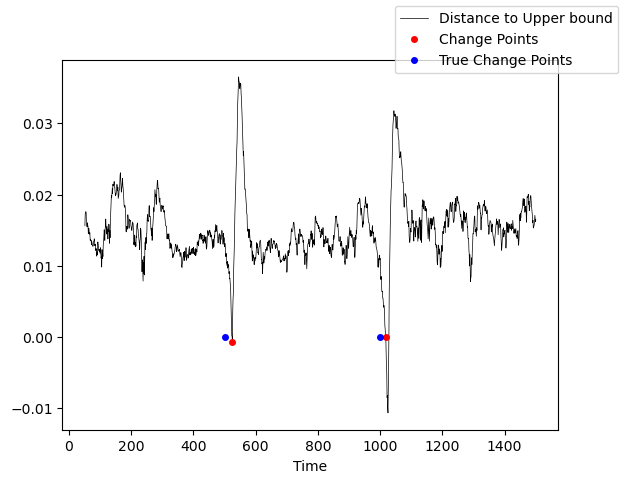

In [15]:
detector.plot(GroundTruth)

In [17]:
f1,cov = [],[]
for k,metrics in METRICS_SWD.items():
    f1.append(metrics['F1'])
    cov.append(metrics['Covering'])

print(np.mean(f1))
print(np.mean(cov))

0.8333333333333333
0.8661535949481861
